In [1]:
from transformers import CLIPProcessor
from PIL import Image
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from pprint import pprint
import tqdm
import matplotlib.pyplot as plt
import numpy as np

/home/sysadm/Music/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Loading the dataset...")
# Load the dataset
dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset")
# dataset['train'], dataset['validation'], dataset['test'

Loading the dataset...


In [3]:
# Check available splits
print("Available splits:", list(dataset.keys()))
print("Number of samples in each split:")
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])}")



Available splits: ['train']
Number of samples in each split:
train: 30633


In [4]:
# Look at one sample
sample = dataset['train'][1]

print("\n--- Sample Data ---")
pprint(sample)



--- Sample Data ---
{'findings': 'Lung volumes remain low. There are innumerable bilateral '
             'scattered small pulmonary nodules which are better demonstrated '
             'on recent CT. Mild pulmonary vascular congestion is stable. The '
             'cardiomediastinal silhouette and hilar contours are unchanged. '
             'Small pleural effusion in the right middle fissure is new. There '
             'is no new focal opacity to suggest pneumonia. There is no '
             'pneumothorax. ',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7668F8093700>,
 'impression': 'Low lung volumes and mild pulmonary vascular congestion is '
               'unchanged. New small right fissural pleural effusion. No new '
               'focal opacities to suggest pneumonia.'}


In [5]:
sample.__sizeof__()

216

In [6]:
sample_image = sample['image']
print("Image size:", sample_image.size)
print("Image mode:", sample_image.mode)

Image size: (512, 512)
Image mode: RGB


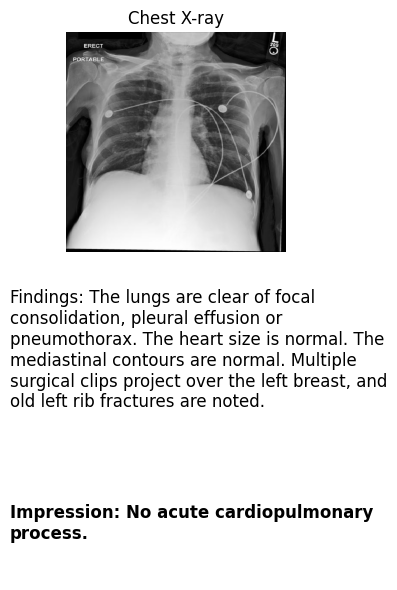

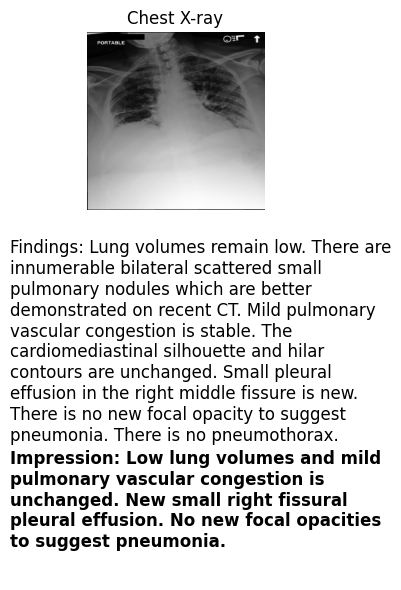

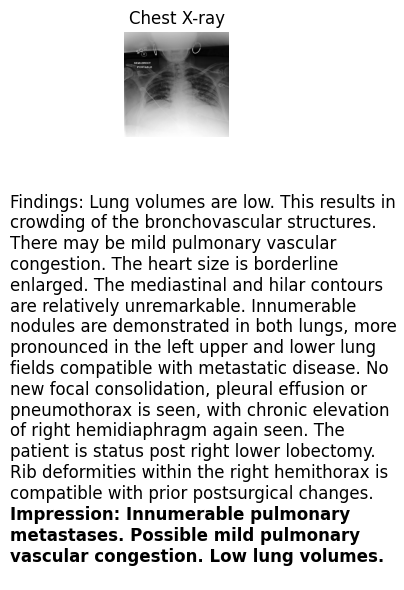

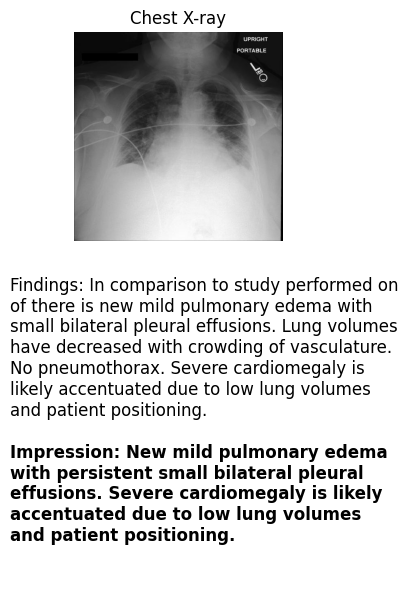

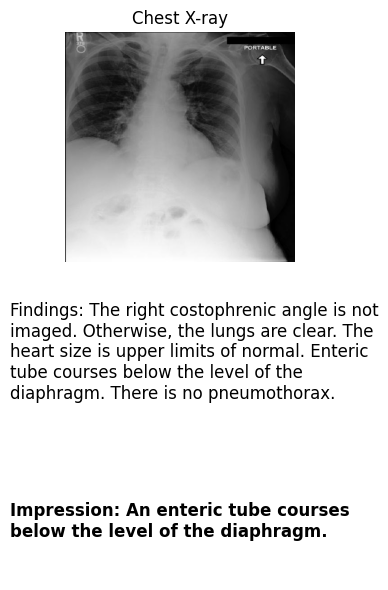

In [7]:
import matplotlib.pyplot as plt

# Assuming sample_data contains your data with the image
def display_sample(sample_data):
    # Extract components
    image = sample_data['image']
    findings = sample_data['findings']
    impression = sample_data['impression']
    
    # Create figure
    plt.figure(figsize=(4,6))
    
    # Display image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Chest X-ray')
    
    # Display text
    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.text(0, 0.8, f"Findings: {findings}", wrap=True, fontsize=12)
    plt.text(0, 0.2, f"Impression: {impression}", wrap=True, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Call the function with your sample data
count = 0
for sample in dataset['train']:
    count += 1
    if count > 5:
        break
    display_sample(sample)  # Replace with your actual variable name
# Replace with your actual variable name

In [8]:
import random

# Define sampling fraction
fraction = 0.001
total_examples = len(dataset["train"])
print("total_examples:",total_examples)
# Define the number of examples to sample
subset_size = int(total_examples * fraction)
print("subset_size:",subset_size)

total_examples: 30633
subset_size: 30


In [9]:
# Randomly sample subset indices from the full dataset
sampled_indices = random.sample(range(total_examples), subset_size)

# Shuffle the subset for randomness
random.shuffle(sampled_indices)

# Split into train and validation from the sampled subset
train_cutoff = int(subset_size * 0.8)
train_indices = sampled_indices[:train_cutoff]
val_indices = sampled_indices[train_cutoff:]

# Apply indices to the original full dataset
dataset["validation"] = dataset["train"].select(val_indices)
dataset["train"] = dataset["train"].select(train_indices)


In [10]:
print("Number of samples in the new train set:", len(dataset["train"]))
print("Number of samples in the new validation set:", len(dataset["validation"]))

Number of samples in the new train set: 24
Number of samples in the new validation set: 6


In [11]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
from torch.utils.data import Dataset

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
# class MIMICCLIPDataset(Dataset):
#     def __init__(self, hf_dataset, processor):
#         self.dataset = hf_dataset
#         self.processor = processor

#     def __getitem__(self, idx):
#         item = self.dataset[idx]
#         image = item["image"]  # already a PIL.Image from dataset
#         text = item.get("impression") or item.get("findings")

#         inputs = self.processor(
#             text=text,
#             images=image,
#             return_tensors="pt",
#             padding=True
#         )
#         return {k: v.squeeze(0) for k, v in inputs.items()}, None

#     def __len__(self):
#         return len(self.dataset)

In [13]:
class MIMICCLIPDataset(Dataset):
    def __init__(self, hf_dataset, processor, max_length=77):
        self.dataset = hf_dataset
        self.processor = processor
        self.max_length = max_length  # CLIP default context length
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]  # already a PIL.Image from dataset
        
        # Preferentially use impression if available, otherwise findings
        text = item.get("impression") or item.get("findings")
        
        # Process with CLIP processor 
        inputs = self.processor(
            text=text,
            images=image,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        
        # Remove batch dimension added by processor
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
    
    def __len__(self):
        return len(self.dataset)

# Example of how to create and use the DataLoader with your dataset
'''
import torch
from torch.utils.data import DataLoader

# Create dataset
train_dataset = MIMICCLIPDataset(train_hf_dataset, processor)

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=16, 
    shuffle=True,
    num_workers=4
)

# Example training loop
for batch, _ in train_loader:
    # batch is now a dict with keys like 'input_ids', 'attention_mask', 'pixel_values'
    # that can be passed directly to your CLIP model
    outputs = model(**batch)
    loss = outputs.loss
    # ... rest of training code
'''

"\nimport torch\nfrom torch.utils.data import DataLoader\n\n# Create dataset\ntrain_dataset = MIMICCLIPDataset(train_hf_dataset, processor)\n\n# Create DataLoader\ntrain_loader = DataLoader(\n    train_dataset,\n    batch_size=16, \n    shuffle=True,\n    num_workers=4\n)\n\n# Example training loop\nfor batch, _ in train_loader:\n    # batch is now a dict with keys like 'input_ids', 'attention_mask', 'pixel_values'\n    # that can be passed directly to your CLIP model\n    outputs = model(**batch)\n    loss = outputs.loss\n    # ... rest of training code\n"

In [14]:
# models/clip/train.py

import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader

import time
from datetime import timedelta

def do_train(model, train_dl, optimizer, lr_scheduler, device):
    train_loss = 0
    model.train()
    start_time = time.time()
    
    for bid, batch in enumerate(train_dl):
        batch_start = time.time()
        if bid % 100 == 0:
            print("...{:d} training steps complete".format(bid))

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss

        train_loss += loss.detach().cpu().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        if bid % 100 == 0 and bid > 0:
            batch_time = time.time() - batch_start
            eta = batch_time * (len(train_dl) - bid)
            print(f"    Batch time: {batch_time:.2f}s | ETA: {str(timedelta(seconds=int(eta)))}")

    total_time = time.time() - start_time
    avg_time_per_batch = total_time / len(train_dl)
    print(f"...{bid} training steps COMPLETE in {str(timedelta(seconds=int(total_time)))}")
    print(f"Average time per batch: {avg_time_per_batch:.2f}s")
    
    return train_loss, total_time

#     return val_loss, val_acc, total_time
def do_eval(model, eval_dl, device):
    model.eval()
    val_loss, val_acc, num_examples = 0, 0, 0
    start_time = time.time()
    
    # Add debugging to check if dataloader is empty
    print(f"Validation dataloader contains {len(eval_dl)} batches")
    
    for bid, batch in enumerate(eval_dl):
        # Print every batch during validation for debugging
        print(f"Validating batch {bid+1}/{len(eval_dl)}")
        
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch, return_loss=True)

        loss = outputs.loss
        val_loss += loss.detach().cpu().numpy()

        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        predictions = torch.argmax(probs, dim=-1)
        labels = torch.arange(len(predictions)).to(device)

        accuracy = torch.sum(predictions == labels)
        num_examples += len(predictions)
        val_acc += accuracy

    total_time = time.time() - start_time
    
    # Avoid division by zero if no examples were processed
    if num_examples > 0:
        val_acc = val_acc.detach().cpu().numpy() / num_examples
    else:
        val_acc = 0.0
        print("WARNING: No examples were processed during validation!")
    
    print(f"Validation complete: Processed {num_examples} examples in {len(eval_dl)} batches")
    
    return val_loss, val_acc, total_time


In [15]:
# Example of setting up training
import torch
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

# Setup dataloaders
train_ds = MIMICCLIPDataset(dataset["train"], processor)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_ds = MIMICCLIPDataset(dataset["validation"], processor)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)
# Check validation dataset size
print(f"Validation dataset size: {len(val_ds)} examples")
print(f"Validation batch size: {val_loader.batch_size}")
print(f"Expected number of batches: {len(val_ds) // val_loader.batch_size + (1 if len(val_ds) % val_loader.batch_size > 0 else 0)}")

# Setup model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training loop
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
    train_loss,train_time = do_train(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, val_acc ,val_time= do_eval(model, val_loader, device)
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Time: {str(timedelta(seconds=int(train_time)))}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Time: {str(timedelta(seconds=int(val_time)))}")

Validation dataset size: 6 examples
Validation batch size: 16
Expected number of batches: 1

🚀 Epoch 1/3


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sysadm/Music/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/sysadm/Music/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/home/sysadm/Music/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/sysadm/Music/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 240, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


In [ ]:
def clip_collate_fn(batch, processor):
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

def main():
    # Load config
    with open("config/clip_config.yaml", "r") as f:
        config = yaml.safe_load(f)

    MODEL_NAME = config["model"]["name"]
    DATASET_NAME = config["dataset"]["name"]
    USE_FINDINGS = config["dataset"].get("use_findings_if_missing", True)
    BATCH_SIZE = config["training"]["batch_size"]
    EPOCHS = int(config["training"]["epochs"])
    LR = float(config["training"]["learning_rate"])
    SAVE_PATH = config["training"]["save_path"]
    EMBED_DIR = config["embeddings"]["save_dir"]

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load processor and model
    print(f"Loading model: {MODEL_NAME}")
    processor = CLIPProcessor.from_pretrained(MODEL_NAME)
    model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
    
    # Load and preprocess dataset
    print(f"Loading dataset: {DATASET_NAME}")
    dataset = load_dataset(DATASET_NAME)
    
    # print("Preprocessing dataset...")
    # data_dir = "data/processed"
    # preprocess_dataset(raw_dataset, output_dir=data_dir)
    # print("Data preprocessing complete")
    # ✅ Manual split if no val/test provided
    if "validation" not in dataset or "test" not in dataset:
        print("\n🔀 Splitting dataset into train/val/test...")
        dataset["train"] = dataset["train"].shuffle(seed=42)
        total = len(dataset["train"])
        train_end = int(0.8 * total)
        val_end = train_end + int(0.1 * total)
        dataset["validation"] = dataset["train"].select(range(train_end, val_end))
        dataset["test"] = dataset["train"].select(range(val_end, total))
        dataset["train"] = dataset["train"].select(range(0, train_end))



train_dataset = CLIPDataset(dataset["train"])
    val_dataset = CLIPDataset(dataset["validation"])
    test_dataset = CLIPDataset(dataset["test"])
    print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    # Create DataLoaders with custom collate function
    custom_collate = lambda batch: clip_collate_fn(batch, processor)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=4, 
        collate_fn=custom_collate
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4, 
        collate_fn=custom_collate
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4, 
        collate_fn=custom_collate
    )
    
    print("\n*******************************************\n")
    print(train_dataset)
    print(train_loader)
    print(val_dataset)
    print(val_loader)
    print("********************************************\n")

    # Create optimizer
    optimizer = AdamW(model.parameters(), lr=LR)

    # Setup for training
    history_path = "results/train_history.tsv"
    os.makedirs(os.path.dirname(history_path), exist_ok=True)
    os.makedirs(SAVE_PATH, exist_ok=True)

    # Create header for history file if it doesn't exist
    if not os.path.exists(history_path):
        with open(history_path, "w") as f:
            f.write("epoch\ttrain_loss\tval_loss\tval_acc_avg\timage_to_text_acc\timage_to_text_top5\ttext_to_image_acc\ttext_to_image_top5\n")

    # Run training loop
    for epoch in range(EPOCHS):
        print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
        
        train_loss, train_time = do_train(model, train_loader, optimizer, epoch, device=device)
        eval_results = do_eval(model, val_loader, device=device)

        val_loss = eval_results["avg_val_loss"]
        image_to_text_acc = eval_results["image_to_text_acc"]
        text_to_image_acc = eval_results["text_to_image_acc"]
        image_to_text_top5 = eval_results["image_to_text_top5"]
        text_to_image_top5 = eval_results["text_to_image_top5"]
        val_time = eval_results["val_time"]
        
        val_acc_avg = (image_to_text_acc + text_to_image_acc) / 2

        print("\n=================================================================================")
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Time: {str(timedelta(seconds=int(train_time)))}")
        print(f"  Val Loss: {val_loss:.4f} | Val Time: {str(timedelta(seconds=int(val_time)))}")
        print(f"  Image→Text: {image_to_text_acc:.4f} (Top-5: {image_to_text_top5:.4f})")
        print(f"  Text→Image: {text_to_image_acc:.4f} (Top-5: {text_to_image_top5:.4f})")

        # Save training history to .tsv
        with open(history_path, "a") as f:
            f.write(f"{epoch+1}\t{train_loss:.4f}\t{val_loss:.4f}\t{val_acc_avg:.4f}\t"
                    f"{image_to_text_acc:.4f}\t{image_to_text_top5:.4f}\t{text_to_image_acc:.4f}\t{text_to_image_top5:.4f}\n")

        # Save checkpoint
        checkpoint_path = os.path.join(SAVE_PATH, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'image_to_text_acc': image_to_text_acc,
            'text_to_image_acc': text_to_image_acc,
        }, checkpoint_path)
        print(f"🧪 Checkpoint saved to {checkpoint_path}")

    
    # Final evaluation on test set
    print("\n=================================================================================")
    print("🔍 Final Evaluation on Test Set")
    test_results = do_eval(model, test_loader, device=device)

    test_loss = test_results["avg_val_loss"]
    test_i2t_acc =test_results["image_to_text_acc"]
    test_t2i_acc =test_results["text_to_image_acc"]
    test_i2t_top5 =test_results["image_to_text_top5"]
    test_t2i_top5 =test_results["text_to_image_top5"]
    test_time =test_results["val_time"]
    # test_acc_avg = (test_i2t_acc + test_t2i_acc) / 2
    
    print(f"📊 Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    # print(f"  Average Accuracy: {test_acc_avg:.4f}")
    print(f"  Image→Text: {test_i2t_acc:.4f} (Top-5: {test_i2t_top5:.4f})")
    print(f"  Text→Image: {test_t2i_acc:.4f} (Top-5: {test_t2i_top5:.4f})")
    
    # Save final model
    model.save_pretrained(SAVE_PATH)
    processor.save_pretrained(SAVE_PATH)
    print(f"✅ Final model saved to {SAVE_PATH}")
    print("\n=================================================================================")


if __name__ == "__main__":
    main()